In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2 as cv
import os 
import glob
import random
from PIL import Image
import os
from torchvision import models
import torchvision.transforms.functional as TF
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import csv
import torch.nn.init as init

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# HELPER FUNCTIONS

In [2]:
def calculate_psnr(sr, hr, data_range=2.0):
    """
    Calculates PSNR between SR and HR tensors in [-1, 1] range.
    sr, hr: Tensors of shape (B, C, H, W)
    """
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(data_range / torch.sqrt(mse))


def initialize_weights(m):
    """
    Standard Kaiming Initialization for ESRGAN components.
    """
    if isinstance(m, nn.Conv2d):
        # Kaiming Normal is standard for LeakyReLU
        init.kaiming_normal_(m.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        
        # Scale down the initial weights slightly (as suggested in ESRGAN paper)
        # to help with stability in deep architectures.
        m.weight.data *= 0.1 
        
        if m.bias is not None:
            init.zeros_(m.bias)
            
    elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.zeros_(m.bias)

# CUSTOM DATASET

In [3]:
class Satellite_dataset(Dataset):
    def __init__(self, root_dir, split = "train"):
        super().__init__()
        self.split = split
        self.lr_dir = os.path.join(root_dir, split, "LR")
        self.hr_dir = os.path.join(root_dir, split, "HR")
        
        self.images_files = sorted(os.listdir(self.lr_dir))
        
        self.lr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        self.hr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
    def __len__(self):
        return len(self.images_files)
    
    def __getitem__(self, index):
        filename = self.images_files[index]
        lr = Image.open(os.path.join(self.lr_dir, filename)).convert("RGB")
        hr = Image.open(os.path.join(self.hr_dir, filename)).convert("RGB")
        
        lr = self.lr_transform(lr)
        hr = self.hr_transform(hr)

        
        return lr, hr

# DATA LOADERS

In [4]:
ROOT_DIR = r"./satellite-processed"
BATCH_SIZE = 32
NUM_WORKERS = 6



train_dataset = Satellite_dataset(ROOT_DIR, "train")
val_dataset = Satellite_dataset(ROOT_DIR, "val")
test_dataset = Satellite_dataset(ROOT_DIR, "test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)

lr, hr = next(iter(train_loader))
print(len(train_loader))
print("lr.shape : ", lr.shape)
print("hr.shape : ", hr.shape)

5753
lr.shape :  torch.Size([32, 3, 32, 32])
hr.shape :  torch.Size([32, 3, 128, 128])


# SAMPLES VISUALISATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7176471..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..-0.42745095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..0.38823533].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60784316..0.30980396].


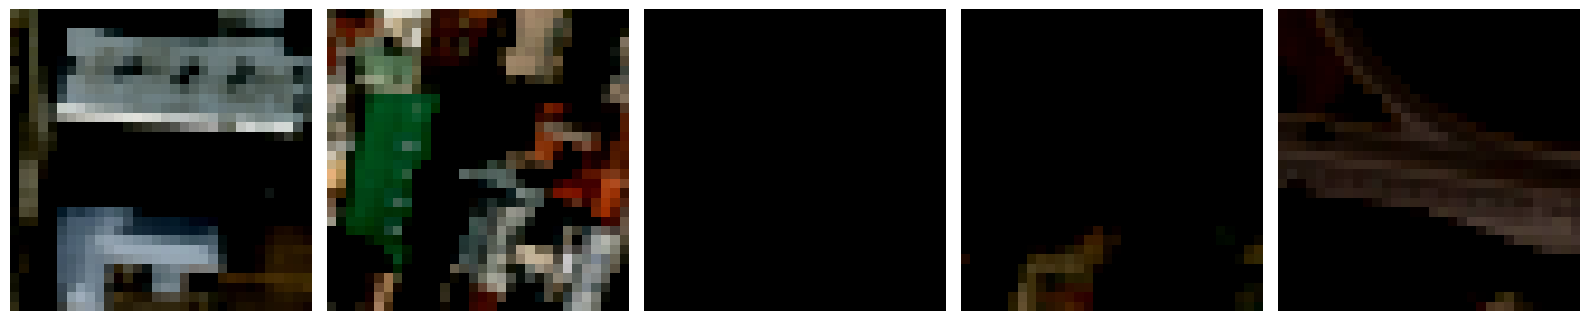

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..-0.1607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..0.4431373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.654902..0.5686275].


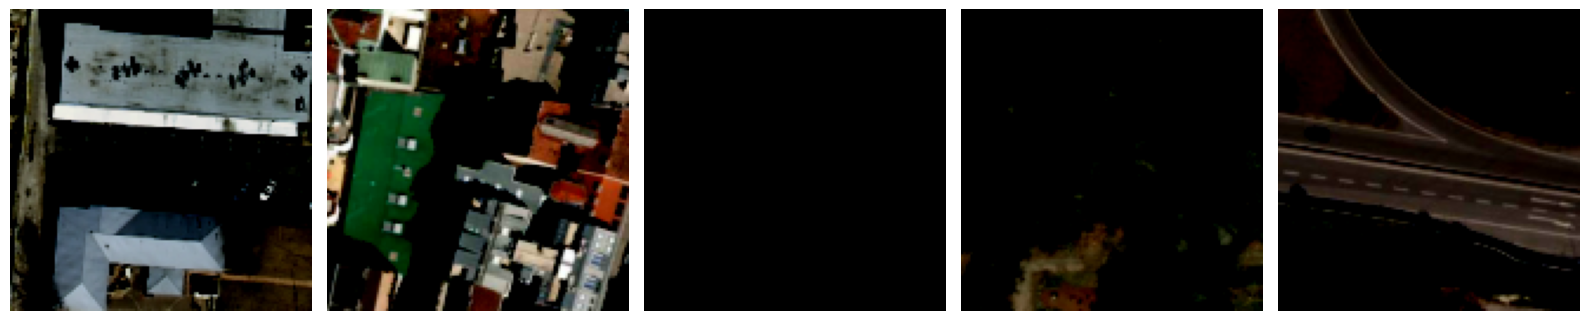

In [5]:
lr, hr = next(iter(train_loader))

# PLOTING LOWER RES IMAGES
plt.figure(figsize=(16, 5))
rows, cols = 1, 5
for i in range(rows * cols):
    img = lr[i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()


# PLOTING HIGHIER RES IMAGES
plt.figure(figsize=(16, 5))
rows, cols = 1, 5
for i in range(rows * cols):
    img = hr[i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()

# GENERATOR NET

In [6]:
GROWTH_RATE = 32
RESIDUAL_SCALE = 0.2
N_DENSE_LAYERS = 4

class Dense_layer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels, growth_rate, 3, 1, 1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        out = self.relu(self.conv(x))
        # dim=1 concatination au niveau des channels
        return torch.cat([x, out], dim=1)

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, n_dense_layers=4, growth_rate=32, residual_scale=0.2):
        super().__init__()
        
        self.residual_scale = residual_scale
        self.rdb = nn.Sequential(*[Dense_layer(in_channels + i * growth_rate, growth_rate) for i in range(n_dense_layers)])
        self.conv = nn.Conv2d(in_channels + n_dense_layers * growth_rate, in_channels, 3, 1, 1)
        
    def forward(self, x):
        out = self.rdb(x)
        return self.conv(out) * self.residual_scale + x
    
class RRDB(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(channels)
        self.rdb2 = ResidualDenseBlock(channels)
        self.rdb3 = ResidualDenseBlock(channels)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return x + 0.2 * out


class GENERATOR(nn.Module):
    def __init__(self, in_channels, num_features, num_blocks):
        super().__init__()
        self.first_conv = nn.Conv2d(in_channels, num_features, 9, 1, 9//2)
        
        self.RRDB = nn.Sequential(
            *[RRDB(num_features) for i in range(num_blocks)]
        )
        
        self.tail_res = nn.Conv2d(num_features, num_features, 3, 1, 1)
        
        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(num_features, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(num_features, 3, 9, 1, 9//2),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.first_conv(x)
        out = self.RRDB(x)
        out = self.tail_res(out) + x
        out = self.upsample(out)
        return out

# DISCRIMINATOR NET

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.LeakyReLU(0.2)
        )
        layers = []
        in_ch = 64
        for _ in range(3):
            layers.append(nn.Sequential(
                nn.Conv2d(in_ch, in_ch, 3, 2, 1),
                nn.BatchNorm2d(in_ch),
                nn.LeakyReLU(0.2),
                nn.Conv2d(in_ch, in_ch*2, 3, 1, 1),
                nn.BatchNorm2d(in_ch*2),
                nn.LeakyReLU(0.2)
            ))
            in_ch *= 2
        self.blocks = nn.Sequential(*layers)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(1024),
            nn.Dropout(0.3),
            nn.LeakyReLU(0.2),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.blocks(x)
        x = self.fc(x)
        return x

# Stage 1: MAXIMAZING PSNR

In [8]:
generator = GENERATOR(3, 64, 18).to(device)
generator.apply(initialize_weights)
loss_fn = torch.nn.L1Loss()
optimiser = torch.optim.Adam(generator.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimiser,
    mode='max',       # maximize PSNR
    factor=0.5,       # LR reduced by half when plateau
    patience=3,       # wait 3 epochs
    min_lr=1e-6,
    verbose=True
)

/home/adnane/miniconda3/envs/torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# HANDLING CHECKPOINTS: LOAD & SAVE

In [9]:
def save_latest(generator, optimiser, scheduler, epoch, base_dir):
    torch.save(generator.state_dict(), os.path.join(base_dir, "latest_gen.pth"))
    torch.save(optimiser.state_dict(), os.path.join(base_dir, "latest_optim.pth"))
    torch.save(scheduler.state_dict(), os.path.join(base_dir, "latest_sched.pth"))
    torch.save(epoch, os.path.join(base_dir, "latest_epoch.pth"))

def save_best(generator, base_dir):
    torch.save(generator.state_dict(), os.path.join(base_dir, "best_gen.pth"))

def load_latest(generator, optimiser, scheduler, base_dir):
    gen_p = os.path.join(base_dir, "latest_gen.pth")
    if os.path.exists(gen_p):
        generator.load_state_dict(torch.load(gen_p))
        optimiser.load_state_dict(torch.load(os.path.join(base_dir, "latest_optim.pth")))
        scheduler.load_state_dict(torch.load(os.path.join(base_dir, "latest_sched.pth")))
        start_epoch = torch.load(os.path.join(base_dir, "latest_epoch.pth")) + 1
        print(f"Resuming from epoch {start_epoch}")
        return start_epoch
    return 0

# Training Function

In [10]:
def train_stage_1(generator, train_loader, val_loader,
                  optimiser, scheduler, loss_fn,
                  epochs, device):

    base_dir = "./checkpoint-ESRGAN/stage-1"
    os.makedirs(base_dir, exist_ok=True)

    start_epoch = load_latest(generator, optimiser, scheduler, base_dir)

    csv_path = os.path.join(base_dir, "stage1_metrics.csv")

    # ---------- Create CSV header ----------
    if not os.path.exists(csv_path):
        with open(csv_path, mode="w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "epoch",
                "train_loss",
                "train_psnr",
                "val_loss",
                "val_psnr"
            ])

    best_psnr = 0.0

    for epoch in range(start_epoch, epochs):

        # ---------- Training ----------
        generator.train()
        train_loss_sum = 0.0
        train_psnr_sum = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for lr_imgs, hr_imgs in pbar:
            lr_imgs = lr_imgs.to(device, non_blocking=True)
            hr_imgs = hr_imgs.to(device, non_blocking=True)

            sr_imgs = generator(lr_imgs)
            loss = loss_fn(sr_imgs, hr_imgs)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()

            train_loss_sum += loss.item()
            train_psnr_sum += calculate_psnr(sr_imgs.detach(), hr_imgs)

            pbar.set_postfix({
                "L1": f"{loss.item():.4f}"
            })

        train_loss = train_loss_sum / len(train_loader)
        train_psnr = train_psnr_sum / len(train_loader)

        # ---------- Validation ----------
        generator.eval()
        val_loss_sum = 0.0
        val_psnr_sum = 0.0

        with torch.no_grad():
            for lr_val, hr_val in val_loader:
                lr_val = lr_val.to(device, non_blocking=True)
                hr_val = hr_val.to(device, non_blocking=True)

                sr_val = generator(lr_val)
                v_loss = loss_fn(sr_val, hr_val)

                val_loss_sum += v_loss.item()
                val_psnr_sum += calculate_psnr(sr_val, hr_val)

        val_loss = val_loss_sum / len(val_loader)
        val_psnr = val_psnr_sum / len(val_loader)

        # ---------- Scheduler ----------
        scheduler.step(val_psnr)

        # ---------- Save checkpoints ----------
        save_latest(generator, optimiser, scheduler, epoch, base_dir)

        if val_psnr > best_psnr:
            best_psnr = val_psnr
            save_best(generator, base_dir)
            print("New best PSNR model saved!")

        # ---------- Print ----------
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train PSNR: {train_psnr:.2f} dB | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val PSNR: {val_psnr:.2f} dB | "
            f"Best: {best_psnr:.2f} dB"
        )

        # ---------- Save to CSV ----------
        with open(csv_path, mode="a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch,
                f"{train_loss:.6f}",
                f"{train_psnr:.3f}",
                f"{val_loss:.6f}",
                f"{val_psnr:.3f}"
            ])


# To Start Training

In [11]:
train_stage_1(
    generator,
    train_loader,
    val_loader,
    optimiser,
    scheduler,
    loss_fn,
    epochs=5,
    device=device
)

/tmp/ipykernel_11138/498121915.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(gen_p))
/tmp/ipykernel_11138/498121915.py:14: Future

Resuming from epoch 2


Epoch 3/5: 100%|██████████| 5753/5753 [52:22<00:00,  1.83it/s, L1=0.0540]


New best PSNR model saved!
Epoch 3/5 | Train Loss: 0.0543 | Train PSNR: 27.08 dB | Val Loss: 0.0543 | Val PSNR: 27.91 dB | Best: 27.91 dB


Epoch 4/5: 100%|██████████| 5753/5753 [52:23<00:00,  1.83it/s, L1=0.0506]


New best PSNR model saved!
Epoch 4/5 | Train Loss: 0.0532 | Train PSNR: 27.23 dB | Val Loss: 0.0533 | Val PSNR: 28.04 dB | Best: 28.04 dB


Epoch 5/5: 100%|██████████| 5753/5753 [52:21<00:00,  1.83it/s, L1=0.0477]


New best PSNR model saved!
Epoch 5/5 | Train Loss: 0.0526 | Train PSNR: 27.33 dB | Val Loss: 0.0529 | Val PSNR: 28.11 dB | Best: 28.11 dB
